This is the primary notebook used when performing the initial model development and testing for the 5 test stations (AC, Cape May, Lewes, Portland and Boston)  Model examples using a range of NN and other ML approaches (logistic regression, random forest, gradient boosting).

This notebook should not be edited after 3/20/2020 - instead, future development should start with a clean notebook.

In [1]:
%matplotlib inline

import os
from pathlib import Path
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import itertools
import dill
import pickle
from scipy import io
from scipy.signal import detrend as detrend
from sklearn.utils import shuffle
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
from sklearn.metrics import brier_score_loss
from sklearn.metrics import roc_auc_score as roc
from sklearn.metrics import roc_curve
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import regularizers
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
#My helper functions
from modelNN_functions import assessTrainTestData
from modelNN_functions import plotConfusionMatrix
from modelNN_functions import pandasToMat

ModuleNotFoundError: No module named 'dill'

In [2]:
dill.load_session('notebook_modelNN_allStations_GDT.db')
#dill.dump_session('notebook_modelNN_allStations_GDT.db')

In [102]:
# Function to calculate the Brier Skill Score
def BSS(targetTrain, modelPrediction, observed):
    
    bs=np.mean([modelPrediction-observed]**2)

    #Calculate the BSS
    climate=np.mean(targetTrain)

    climForecast=np.ones(np.shape(observed)) * climate

    bsClimate=np.mean((climForecast-observed)**2)

    bssOut=1-(bs/bsClimate)
    
    return bssOut


This is function to combine the steps of setting up, fitting and evaluating our NN model

In [83]:
def runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets, 
               epochCount, batchCount, classThreshold, numFeatures):

    """
    where: 
        featureTrain = features used in training the model
        targetTrain = targets (0 or 1) used in training the model
        featureTest = features used for validation
        targetTest = targets (0 or 1) used for valdation
        predictFeatures = the features for the model predictions
        predictTargets = the targets for the model predictions
        epochCount = number of training cycles to use for NN model (10-20 seems reasonable)
        batchCount = the batch size to use when training (somewhere from 32-256 seems reasonable)
        classThreshold = the threshold from 0 to 1 used to classify a point as good or bad (default is 0.5)
        numFeatures = the number of input features in the NN model
    """

    #First define the keras NN framework to be used
    # For a single-input model with 2 classes (binary classification):
    model = Sequential()
    #model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_dim=numFeatures))
    model.add(Dense(32, activation='relu', input_dim=numFeatures))
    #model.add(Dropout(0.25))
    #model.add(Dense(16, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
    model.add(Dense(32, activation='relu', input_dim=numFeatures))
    #model.add(Dropout(0.25))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    #Set up the model checkpoint
    # checkpoint
    filepath="model_best.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='min')
    callbacks_list = [checkpoint]
    
    # Train the model, iterating on the data in batches of X # samples (somewhere between 32 - 256)
    history = model.fit(featureTrain, targetTrain, epochs=epochCount, batch_size=batchCount, validation_data=(featureTest, targetTest), callbacks=callbacks_list)
    
    #Evaulate the model
    eval_model=model.evaluate(featureTest, targetTest)
    eval_model
    
    #Plot the NN accuracy over each epoch
    fig, ax = plt.subplots()
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.legend(['Training','Validation'])
    plt.show()
    #fig.savefig('NN_modelTrainingHistory.png')
    
    #Generate predictions for the test period
    modelPrediction = model.predict(featureTest, batch_size=32)

    #And now use the threhsold to decide y or n
    modelPredThresh=1*(modelPrediction >= classThreshold)

    # Compute confusion matrix
    cnfMatrix = confusion_matrix(targetTest, modelPredThresh)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    classNames = ['bad data point','good data point']
    plotConfusionMatrix(cnfMatrix, classes=classNames,normalize=True,
                      title='Confusion matrix, with normalization')
    plt.show()
    
    #Generate model predictions for the validation period
    modelPrediction = model.predict(predictFeatures, batch_size=32)
    #Generate the y/n prediction given the above model threshold value (right now = 0.9)
    modelPredThresh=1*(modelPrediction >= classThreshold)
    
    modelOut = pd.DataFrame()
    modelOut['primary'] = predictFeatures['primary']
    modelOut['modelPrediction']=modelPrediction
    modelOut['InvModelPrediction']=1-modelPrediction
    modelOut['goodPtsPrediction']=modelPredThresh
    modelOut['targets'] = predictTargets['targets']
    
    return modelOut, model


Read in the data from the files and do some initial prep

In [64]:
#cleaned = pd.read_pickle(Path("pickle_files/8536110_cm_raw_ver_merged_wl_Cleaned"))
#cleaned = pd.read_pickle(Path("pickle_files/8557380_lewes_raw_ver_merged_wl_Cleaned"))
#cleaned = pd.read_pickle(Path("pickle_files/8534720_ac_raw_ver_merged_wl_Cleaned"))
#cleaned = pd.read_pickle(Path("pickle_files/8443970_boston_raw_ver_merged_wl_Cleaned"))
cleaned = pd.read_pickle(Path("pickle_files/8418150_portland_raw_ver_merged_wl_Cleaned"))

#cleaned.head()

In [65]:
# Trying to modify the scaling to use the GDT range as the scaling factor to see if this helps (and also NOT scaling residual)
#Scaling - trying scaling by the Great Diurnal range, and NOT scaling residual.  The residual is fairly normally distributed about 0 and the observed and predicted values run pretty consistently 
#between -1 and 1 when scaled the GDT range (thought about using the 1/5 range - .

CapeMayRange= 1.659
LewesRange = 1.418
ACRange = 1.403
BostonRange = 3.131
PortlandRange = 3.019


GDTrange = PortlandRange

In [66]:
#IMPT if you run this cell twice it will mess up since I am replacing all the NaNs (e.g. the next time through will have none)

primaryTrue = cleaned['primary'].notnull()
cleaned['primaryTrue'] = primaryTrue * 1

sigmaTrue = cleaned['sigma'].notnull()
cleaned['sigmaTrue'] = sigmaTrue * 1

backupTrue = cleaned['backup'].notnull()
cleaned['backupTrue'] = backupTrue * 1


cleaned['primary'].fillna(value=0, inplace = True)
cleaned['sigma'].fillna(value=0, inplace = True)
cleaned['backup'].fillna(value=0, inplace = True)
cleaned['residual'].fillna(value=0, inplace = True)

In [67]:
cleaned['primary'] = cleaned['primary'].mask(cleaned['primary'] >5, 5)
cleaned['primary'] = cleaned['primary'].mask(cleaned['primary'] < -5, -5)

cleaned['backup'] = cleaned['backup'].mask(cleaned['backup'] >5, 5)
cleaned['backup'] = cleaned['backup'].mask(cleaned['backup'] < -5, -5)

cleaned['residual'] = cleaned['residual'].mask(cleaned['residual'] >5, 5)
cleaned['residual'] = cleaned['residual'].mask(cleaned['residual'] < -5, -5)

cleaned['sigma'] = cleaned['sigma'].mask(cleaned['sigma'] > 1, 1)
cleaned['sigma'] = cleaned['sigma'].mask(cleaned['sigma'] < 0, 0)

In [68]:
#Now create a previous 6 minute value and following 6 minute value of the primary (and boolean) and the residual (and boolean)
cleaned['primaryPrev6']=cleaned['primary'].shift(periods = 1)
cleaned['primaryTruePrev6']=cleaned['primaryTrue'].shift(periods = 1)
cleaned['residualPrev6']=cleaned['residual'].shift(periods = 1)

cleaned['primaryNext6']=cleaned['primary'].shift(periods = -1)
cleaned['primaryTrueNext6']=cleaned['primaryTrue'].shift(periods = -1)
cleaned['residualNext6']=cleaned['residual'].shift(periods = -1)

#And try grabbing the previous 12 hours of residual and calculating the # of missing data, mean and std as inputs
cleaned['dataCountPrev12h']= (cleaned['primaryTrue'].rolling('12H').sum() / 120)
cleaned['residualMeanPrev12h']= cleaned['residual'][cleaned['primaryTrue'] == 1].rolling('12H').mean() 
cleaned['residualStdPrev12h'] = cleaned['residual'][cleaned['primaryTrue'] == 1].rolling('12H').std() 

#And drop the first and last 12h (120 points)
cleaned.drop(cleaned.head(120).index, inplace=True)
cleaned.drop(cleaned.tail(120).index, inplace=True)

#And drop all the rows where the primaryTrue and verifed = 0 (since we already know these are bad, as they are missing)
cleaned = cleaned[cleaned.primaryTrue == 1]
cleaned = cleaned.dropna()

In [69]:
# Get names of scaled features
namesGDTScaled = ['primary','primaryPrev6','primaryNext6','backup','prediction']
namesNotScaled = ['targets','residual','residualPrev6','residualNext6','primaryTrue',
                  'primaryTruePrev6','primaryTrueNext6','sigmaTrue','backupTrue',
                  'dataCountPrev12h','residualMeanPrev12h','residualStdPrev12h']

cleanedScaled=cleaned.copy()
#demean and divide by GDTrange
#for name in namesGDTScaled:
#    cleanedScaled.loc[:,name] = detrend(cleanedScaled.loc[:,name])

cleanedScaled.loc[:,namesGDTScaled] = cleanedScaled.loc[:,namesGDTScaled] / GDTrange

cleanedScaled.head()

,primary,sigma,backup,verified,prediction,residual,targets,primaryTrue,sigmaTrue,backupTrue,primaryPrev6,primaryTruePrev6,residualPrev6,primaryNext6,primaryTrueNext6,residualNext6,dataCountPrev12h,residualMeanPrev12h,residualStdPrev12h
time,,,,,,,,,,,,,,,,,,,
2007-01-01 12:00:00,0.434581,0.010,0.0,1.312,0.393508,0.124,1.0,1,1,0,0.419013,1.0,0.133,0.455780,1.0,0.135,1.0,0.056450,0.029634
2007-01-01 12:06:00,0.455780,0.010,0.0,1.376,0.411063,0.135,1.0,1,1,0,0.434581,1.0,0.124,0.474329,1.0,0.141,1.0,0.057250,0.030444
2007-01-01 12:12:00,0.474329,0.011,0.0,1.432,0.427625,0.141,1.0,1,1,0,0.455780,1.0,0.135,0.490891,1.0,0.143,1.0,0.058108,0.031335
2007-01-01 12:18:00,0.490891,0.008,0.0,1.482,0.443524,0.143,1.0,1,1,0,0.474329,1.0,0.141,0.506459,1.0,0.146,1.0,0.058883,0.032269
2007-01-01 12:24:00,0.506459,0.006,0.0,1.529,0.458099,0.146,1.0,1,1,0,0.490891,1.0,0.143,0.519709,1.0,0.144,1.0,0.059733,0.033204


In [70]:
trainScaled = cleanedScaled.loc[:'2015-12-31 23:54:00']
testScaled = cleanedScaled.loc['2016-01-01 00:00:00':]

Now I need to save as named datasets

In [71]:
#capeMayTrain=trainScaled.copy()
#capeMayTest=testScaled.copy()
#capeMayTrain['stationName']='Cape May'
#capeMayTest['stationName']='Cape May'

#lewesTrain=trainScaled.copy()
#lewesTest=testScaled.copy()
#lewesTrain['stationName']='Lewes'
#lewesTest['stationName']='Lewes'

#acTrain=trainScaled.copy()
#acTest=testScaled.copy()
#acTrain['stationName']='Atlantic City'
#acTest['stationName']='Atlantic City'

#bostonTrain=trainScaled.copy()
#bostonTest=testScaled.copy()
#bostonTrain['stationName']='Boston'
#bostonTest['stationName']='Boston'

portlandTrain=trainScaled.copy()
portlandTest=testScaled.copy()
portlandTrain['stationName']='Portland'
portlandTest['stationName']='Portland'



In [72]:
del trainScaled
del testScaled

Now combine the sets to one training and test dataframe

In [73]:
trainScaled = pd.concat([capeMayTrain, lewesTrain, acTrain, bostonTrain, portlandTrain])
testScaled = pd.concat([capeMayTest, lewesTest, acTest, bostonTest, portlandTest])

Do some comparisons to see the y/n reprentations between Train and Test sets

In [74]:
(totalTrainData, noTrainData) = assessTrainTestData(trainScaled,testScaled)

Training Data Points
3912096
Data manually QCed as 0 or bad
77997.0
Fraction of data points which are bad
0.01993739417437609


Testing Data Points
822594
Data manually QCed as 0 or bad
11750.0
Fraction of data points which are bad
0.01428408181922066


In [75]:
#This is to remove some of the yes points to make the dataset smaller, and ensure the model puts adequate weight on no points

#What is the fraction of no that we want
fractionNo = 0.10

#What is the number of yes points we need to have given that No fraction
numYes = int(noTrainData * ((1-fractionNo) // fractionNo))

# Divide by class
class_0 = trainScaled[trainScaled['targets'] == 0]
class_1 = trainScaled[trainScaled['targets'] == 1]

In [76]:
#Now resample the yes or 1s to be 90% of total training data
class_1_resample = class_1.sample(numYes)
trainResample = pd.concat([class_1_resample, class_0], axis=0)

print('Random under-sampling:')
print(trainResample.targets.value_counts())

Random under-sampling:
1.0    623976
0.0     77997
Name: targets, dtype: int64


Shuffle the individual training and testing sections to aid with NN fit

In [77]:
trainRand=shuffle(trainResample)
testRand=shuffle(testScaled)
testRand.head()

,primary,sigma,backup,verified,prediction,residual,targets,primaryTrue,sigmaTrue,backupTrue,primaryPrev6,primaryTruePrev6,residualPrev6,primaryNext6,primaryTrueNext6,residualNext6,dataCountPrev12h,residualMeanPrev12h,residualStdPrev12h,stationName
time,,,,,,,,,,,,,,,,,,,,
2016-06-19 05:48:00,-0.363507,0.002,-0.367783,-0.510,-0.383464,0.028,1.0,1,1,1,-0.354241,1.0,0.027,-0.376336,1.0,0.024,1.0,0.028450,0.010902,Atlantic City
2017-11-21 00:54:00,-0.394833,0.007,0.000000,-1.192,-0.363697,-0.094,1.0,1,1,0,-0.410070,1.0,-0.092,-0.375952,1.0,-0.088,1.0,-0.048033,0.032321,Portland
2017-01-15 09:54:00,-0.893309,0.007,0.000000,-0.741,-1.065702,0.143,1.0,1,1,0,-0.924653,1.0,0.133,-0.870404,1.0,0.145,1.0,0.095700,0.026771,Cape May
2017-05-29 18:06:00,0.526093,0.008,0.535966,0.746,0.279972,0.349,1.0,1,1,1,0.548660,1.0,0.356,0.513399,1.0,0.357,1.0,0.387533,0.042955,Lewes
2016-04-15 22:30:00,0.332858,0.006,0.327869,0.467,0.235923,0.136,1.0,1,1,1,0.343550,1.0,0.134,0.318603,1.0,0.134,1.0,0.124350,0.022814,Atlantic City


In [78]:
featureNames = ['primary','primaryPrev6','primaryNext6','sigma','backup','prediction','residual',
                              'residualPrev6','residualNext6','primaryTruePrev6','primaryTrueNext6',
                              'sigmaTrue','backupTrue','dataCountPrev12h','residualMeanPrev12h','residualStdPrev12h']

featureTrain=trainRand.loc[:, featureNames]
featureTest=testRand.loc[:, featureNames]

targetTrain=trainRand.loc[:,['targets']]
targetTest=testRand.loc[:,['targets']]


predictFeatures = testScaled.loc[:, featureNames]
predictTargets = testScaled.loc[:,['targets']]

Train on 701973 samples, validate on 822594 samples
Epoch 1/20
701973/701973 [==============================] - 34s 48us/step - loss: 0.0540 - accuracy: 0.9841 - val_loss: 0.0251 - val_accuracy: 0.9921
Epoch 2/20
701973/701973 [==============================] - 32s 46us/step - loss: 0.0371 - accuracy: 0.9890 - val_loss: 0.0237 - val_accuracy: 0.9933
Epoch 3/20
701973/701973 [==============================] - 32s 45us/step - loss: 0.0341 - accuracy: 0.9899 - val_loss: 0.0220 - val_accuracy: 0.9943
Epoch 4/20
701973/701973 [==============================] - 34s 48us/step - loss: 0.0321 - accuracy: 0.9902 - val_loss: 0.0211 - val_accuracy: 0.9946
Epoch 5/20
701973/701973 [==============================] - 33s 47us/step - loss: 0.0309 - accuracy: 0.9908 - val_loss: 0.0215 - val_accuracy: 0.9946
Epoch 6/20
701973/701973 [==============================] - 33s 46us/step - loss: 0.0299 - accuracy: 0.9911 - val_loss: 0.0212 - val_accuracy: 0.9948
Epoch 7/20
701973/701973 [======================

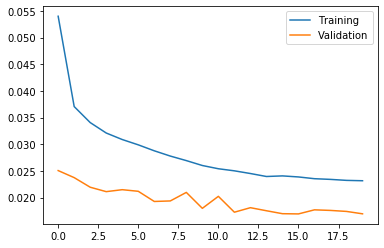

Normalized confusion matrix
[[8.30e-01 1.70e-01]
 [3.76e-04 1.00e+00]]
total accuracy = 0.9972


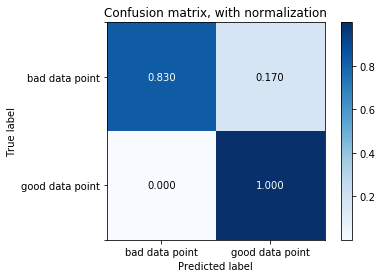

In [79]:
#All 5 10% no - with 0.25 dropout - Optimum model setup

epochCount = 20
batchCount = 128
classThreshold = .50
numFeatures = len(featureNames)
modelOut_all5, model_all5 = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets,
               epochCount, batchCount, classThreshold, numFeatures)

In [120]:
BSS(trainScaled['targets'], modelOut_all5['modelPrediction'], modelOut_all5['targets'])

0.8065226065730016

In [5]:
#The Area under the ROC score
roc(1-modelOut_all5['targets'],1-modelOut_all5['modelPrediction'])

0.9570861850069122

In [3]:
#Now for the simple model
featureNames = ['primary','sigma','backup','prediction','residual',
                              'sigmaTrue','backupTrue']

featureTrain=trainRand.loc[:, featureNames]
featureTest=testRand.loc[:, featureNames]

targetTrain=trainRand.loc[:,['targets']]
targetTest=testRand.loc[:,['targets']]


predictFeatures = testScaled.loc[:, featureNames]
predictTargets = testScaled.loc[:,['targets']]




Train on 701973 samples, validate on 822594 samples
Epoch 1/20
701973/701973 [==============================] - 17s 24us/step - loss: 0.0929 - accuracy: 0.9743 - val_loss: 0.0504 - val_accuracy: 0.9860
Epoch 2/20
701973/701973 [==============================] - 17s 24us/step - loss: 0.0606 - accuracy: 0.9851 - val_loss: 0.0537 - val_accuracy: 0.9832
Epoch 3/20
701973/701973 [==============================] - 16s 23us/step - loss: 0.0517 - accuracy: 0.9879 - val_loss: 0.0574 - val_accuracy: 0.9837
Epoch 4/20
701973/701973 [==============================] - 16s 23us/step - loss: 0.0449 - accuracy: 0.9901 - val_loss: 0.0405 - val_accuracy: 0.9871
Epoch 5/20
701973/701973 [==============================] - 16s 23us/step - loss: 0.0402 - accuracy: 0.9915 - val_loss: 0.0288 - val_accuracy: 0.9932
Epoch 6/20
701973/701973 [==============================] - 16s 22us/step - loss: 0.0379 - accuracy: 0.9922 - val_loss: 0.0417 - val_accuracy: 0.9885
Epoch 7/20
701973/701973 [======================

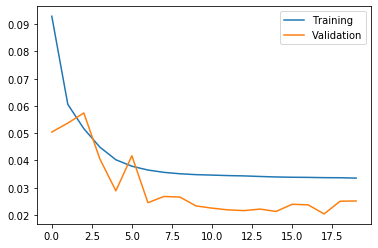

Normalized confusion matrix
[[0.83 0.17]
 [0.   1.  ]]
total accuracy = 0.9956


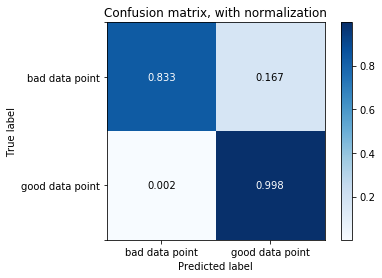

In [85]:
#All 5 10% no - Simple model - with 32x2 and 0.25% dropout

epochCount = 20
batchCount = 256
classThreshold = .50
numFeatures = len(featureNames)
modelOut_all5_simple, model_all5_simple = runNNmodel(featureTrain, targetTrain, featureTest, targetTest, predictFeatures, predictTargets,
               epochCount, batchCount, classThreshold, numFeatures)

In [3]:
#Load the best simple 5 station model
model = load_model('model_best_NNall_simple.hdf5')

In [4]:
#Generate predictions from the best model
modelPrediction = model.predict(predictFeatures, batch_size=256)

In [18]:
#Generate example predictions for Cape May
#Now for the simple model
featureNames = ['primary','sigma','backup','prediction','residual',
                              'sigmaTrue','backupTrue']


predictFeatures = acTest.loc[:, featureNames]
predictTargets = acTest.loc[:,['targets']]
modelPrediction = model.predict(predictFeatures, batch_size=256)
modelOut=acTest.copy()
modelOut['modelPrediction']=modelPrediction

In [19]:
pandasToMat(modelOut, predictFeatures, 'AC')

In [142]:
BSS(trainScaled['targets'], np.reshape(modelPrediction,-1), modelOut_all5_simple['targets'])

0.7755777040793201

In [8]:
#The Area under the ROC score
roc(modelOut_all5['targets'],np.reshape(modelPrediction,-1))

0.9416349299080748

In [14]:
fpr, tpr, rocThresh = roc_curve(modelOut_all5['targets'],np.reshape(modelPrediction,-1))

Normalized confusion matrix
[[8.32e-01 1.68e-01]
 [7.81e-04 9.99e-01]]
total accuracy = 0.9968


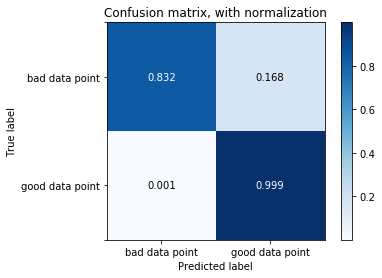

In [22]:
#This is for testing different thresholds with the results of the model

classThreshold =.5
modelPredThresh=1*(modelPrediction >= classThreshold)

# Compute confusion matrix
cnfMatrix = confusion_matrix(modelOut_all5_simple['targets'] , modelPredThresh)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
classNames = ['bad data point','good data point']
plotConfusionMatrix(cnfMatrix, classes=classNames,normalize=True,
                    title='Confusion matrix, with normalization')
#plt.show()
plt.savefig('NN_model_simple_confusion.png')

In [4]:
#This is to prep targets for fitting in scikit-learn
targetTrainIn=np.ravel(targetTrain)
targetTestIn=np.ravel(targetTest)

In [14]:
%%time
# Fitting a Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=10000)
clf.fit(featureTrain, targetTrainIn)

/home/jupyter-greg-dusek/.conda/envs/wlai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 2.46 s, sys: 19.4 ms, total: 2.48 s
Wall time: 2.48 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
# prediction on the training dataset
trainAccuracy = 1 - np.sum(np.abs(clf.predict(featureTrain) - targetTrainIn))/len(targetTrainIn)
print('Accuracy on the train dataset is '+ str(trainAccuracy))

Accuracy on the train dataset is 0.9683833993615139


In [16]:
# prediction on the testing dataset
testAccuracy = 1 - np.sum(np.abs(clf.predict(featureTest) - targetTestIn))/len(targetTestIn)
print('Accuracy on the test dataset is '+ str(testAccuracy))

Accuracy on the test dataset is 0.9891842148131399


In [119]:
#What is the Brier Skill Score
# Function to calculate the Brier Skill Score
modelPred = clf.predict(featureTest)
BSS(trainScaled['targets'], modelPred, targetTestIn)


0.23357568020576636

In [146]:
#What is the Area under the ROC
roc(targetTestIn,modelPred)

0.7098484394038804

In [95]:
predictProb = clf.predict_proba(featureTest)[:,1]

Normalized confusion matrix
[[0.42 0.58]
 [0.   1.  ]]
total accuracy = 0.9892


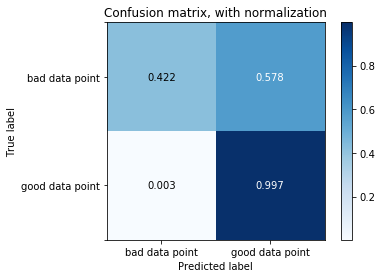

In [96]:
#What is the confusion matrix?

classThreshold =.5
modelPredThresh=1*(predictProb >= classThreshold)

# Compute confusion matrix
cnfMatrix = confusion_matrix(targetTestIn , modelPredThresh)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
classNames = ['bad data point','good data point']
plotConfusionMatrix(cnfMatrix, classes=classNames,normalize=True,
                    title='Confusion matrix, with normalization')
plt.show()


In [194]:
%%time
from sklearn.ensemble import RandomForestClassifier
# Fitting a Random Forest
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=20, min_samples_leaf=2)
clf.fit(featureTrain, targetTrainIn)

CPU times: user 9min 18s, sys: 92.7 ms, total: 9min 18s
Wall time: 1min 10s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
#Save model to pickle file

In [4]:
pickle.dump(clf, open('model_randomForrest_simple', 'wb'))

In [148]:
# prediction on the training dataset
trainAccuracy = 1 - np.sum(np.abs(clf.predict(featureTrain) - targetTrainIn))/len(targetTrainIn)
print('Accuracy on the train dataset is '+ str(trainAccuracy))

Accuracy on the train dataset is 0.9941906597547199


In [149]:
# prediction on the testing dataset
testAccuracy = 1 - np.sum(np.abs(clf.predict(featureTest) - targetTestIn))/len(targetTestIn)
print('Accuracy on the test dataset is '+ str(testAccuracy))

Accuracy on the test dataset is 0.9971577716346095


In [150]:
#What is the feature importance?
for name, score in zip(featureTrain.columns, clf.feature_importances_):
    print(name, score)

primary 0.14056957807801196
sigma 0.5001898816577759
backup 0.02647301543003313
prediction 0.012306615652527133
residual 0.27959488919654624
sigmaTrue 0.03976452986812125
backupTrue 0.001101490116984371


In [151]:
#What is the Brier Skill Score
# Function to calculate the Brier Skill Score
modelPred = clf.predict(featureTest)
BSS(trainScaled['targets'], modelPred, targetTestIn)


0.7985950253255121

In [152]:
roc(targetTestIn,modelPred)

0.9158174790711899

In [153]:
predictProb = clf.predict_proba(featureTest)[:,1]

Normalized confusion matrix
[[8.32e-01 1.68e-01]
 [4.50e-04 1.00e+00]]
total accuracy = 0.9972


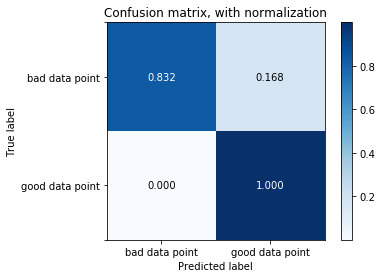

In [154]:
#What is the confusion matrix?

classThreshold =.5
modelPredThresh=1*(predictProb >= classThreshold)

# Compute confusion matrix
cnfMatrix = confusion_matrix(targetTestIn , modelPredThresh)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
classNames = ['bad data point','good data point']
plotConfusionMatrix(cnfMatrix, classes=classNames,normalize=True,
                    title='Confusion matrix, with normalization')
plt.show()


In [18]:
%%time
# Fitting a Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, min_samples_leaf=1)
clf.fit(featureTrain, targetTrainIn)

CPU times: user 1min 30s, sys: 95.1 ms, total: 1min 30s
Wall time: 1min 30s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=2, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [19]:
# prediction on the training dataset
trainAccuracy = 1 - np.sum(np.abs(clf.predict(featureTrain) - targetTrainIn))/len(targetTrainIn)
print('Accuracy on the train dataset is '+ str(trainAccuracy))

Accuracy on the train dataset is 0.9932946138954062


In [20]:
# prediction on the testing dataset
testAccuracy = 1 - np.sum(np.abs(clf.predict(featureTest) - targetTestIn))/len(targetTestIn)
print('Accuracy on the test dataset is '+ str(testAccuracy))

Accuracy on the test dataset is 0.9968453453343934


In [8]:
#What is the Brier Skill Score
# Function to calculate the Brier Skill Score
modelPred = clf.predict(featureTest)
BSS(trainScaled['targets'], modelPred, targetTestIn)

0.7792987403267588

In [9]:
roc(targetTestIn,modelPred)

0.9156793513918831

In [160]:
predictProb = clf.predict_proba(featureTest)[:,1]

Normalized confusion matrix
[[8.32e-01 1.68e-01]
 [6.24e-04 9.99e-01]]
total accuracy = 0.9970


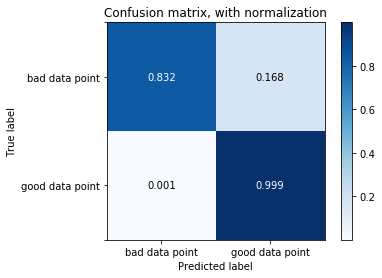

In [161]:
#What is the confusion matrix?

classThreshold =.5
modelPredThresh=1*(predictProb >= classThreshold)

# Compute confusion matrix
cnfMatrix = confusion_matrix(targetTestIn , modelPredThresh)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
classNames = ['bad data point','good data point']
plotConfusionMatrix(cnfMatrix, classes=classNames,normalize=True,
                    title='Confusion matrix, with normalization')
plt.show()


In [162]:
# Now testing the more complicated model with the sci kit learn options

featureNames = ['primary','primaryPrev6','primaryNext6','sigma','backup','prediction','residual',
                              'residualPrev6','residualNext6','primaryTruePrev6','primaryTrueNext6',
                              'sigmaTrue','backupTrue','dataCountPrev12h','residualMeanPrev12h','residualStdPrev12h']

featureTrain=trainRand.loc[:, featureNames]
featureTest=testRand.loc[:, featureNames]

targetTrain=trainRand.loc[:,['targets']]
targetTest=testRand.loc[:,['targets']]


predictFeatures = testScaled.loc[:, featureNames]
predictTargets = testScaled.loc[:,['targets']]

In [163]:
#This is to prep targets for fitting in scikit-learn
targetTrainIn=np.ravel(targetTrain)
targetTestIn=np.ravel(targetTest)

In [164]:
%%time
# Fitting a Logistic Regression
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=10000)
clf.fit(featureTrain, targetTrainIn)

/home/jupyter-greg-dusek/.conda/envs/wlai/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


CPU times: user 4.82 s, sys: 672 ms, total: 5.49 s
Wall time: 5.49 s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [165]:
# prediction on the training dataset
trainAccuracy = 1 - np.sum(np.abs(clf.predict(featureTrain) - targetTrainIn))/len(targetTrainIn)
print('Accuracy on the train dataset is '+ str(trainAccuracy))

Accuracy on the train dataset is 0.9797812736387297


In [166]:
# prediction on the testing dataset
testAccuracy = 1 - np.sum(np.abs(clf.predict(featureTest) - targetTestIn))/len(targetTestIn)
print('Accuracy on the test dataset is '+ str(testAccuracy))

Accuracy on the test dataset is 0.9912958275893089


In [167]:
#What is the Brier Skill Score
# Function to calculate the Brier Skill Score
modelPred = clf.predict(featureTest)
BSS(trainScaled['targets'], modelPred, targetTestIn)


0.3832080330755634

In [168]:
#What is the Area under the ROC
roc(targetTestIn,modelPred)

0.7581820374819324

In [169]:
predictProb = clf.predict_proba(featureTest)[:,1]

Normalized confusion matrix
[[0.52 0.48]
 [0.   1.  ]]
total accuracy = 0.9913


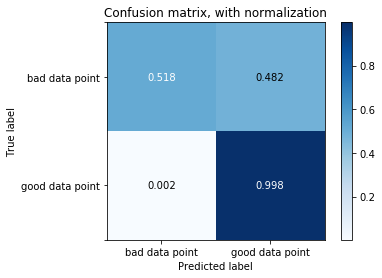

In [170]:
#What is the confusion matrix?

classThreshold =.5
modelPredThresh=1*(predictProb >= classThreshold)

# Compute confusion matrix
cnfMatrix = confusion_matrix(targetTestIn , modelPredThresh)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
classNames = ['bad data point','good data point']
plotConfusionMatrix(cnfMatrix, classes=classNames,normalize=True,
                    title='Confusion matrix, with normalization')
plt.show()


In [171]:
%%time
from sklearn.ensemble import RandomForestClassifier
# Fitting a Random Forest
clf = RandomForestClassifier(n_estimators=200, n_jobs=-1, max_depth=20, min_samples_leaf=2)
clf.fit(featureTrain, targetTrainIn)

CPU times: user 15min 1s, sys: 252 ms, total: 15min 1s
Wall time: 1min 54s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=20, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [172]:
# prediction on the training dataset
trainAccuracy = 1 - np.sum(np.abs(clf.predict(featureTrain) - targetTrainIn))/len(targetTrainIn)
print('Accuracy on the train dataset is '+ str(trainAccuracy))

Accuracy on the train dataset is 0.9980953683403777


In [173]:
# prediction on the testing dataset
testAccuracy = 1 - np.sum(np.abs(clf.predict(featureTest) - targetTestIn))/len(targetTestIn)
print('Accuracy on the test dataset is '+ str(testAccuracy))

Accuracy on the test dataset is 0.9972465152918694


In [174]:
#What is the feature importance?
for name, score in zip(featureTrain.columns, clf.feature_importances_):
    print(name, score)

primary 0.02413659629968086
primaryPrev6 0.007821293760235147
primaryNext6 0.017025669741942567
sigma 0.23074690247263024
backup 0.007548143059587883
prediction 0.003281043215534196
residual 0.12763910684199764
residualPrev6 0.09288084982459228
residualNext6 0.0930483045452845
primaryTruePrev6 2.6803877175063746e-05
primaryTrueNext6 1.7788982145983658e-05
sigmaTrue 0.016685024593134343
backupTrue 0.0005212386481419835
dataCountPrev12h 0.0017196637721989606
residualMeanPrev12h 0.05575395002706904
residualStdPrev12h 0.3211476203386494


In [175]:
#What is the Brier Skill Score
# Function to calculate the Brier Skill Score
modelPred = clf.predict(featureTest)
BSS(trainScaled['targets'], modelPred, targetTestIn)


0.8048835467759987

In [176]:
roc(targetTestIn,modelPred)

0.9153173187444195

In [177]:
predictProb = clf.predict_proba(featureTest)[:,1]

Normalized confusion matrix
[[8.31e-01 1.69e-01]
 [3.44e-04 1.00e+00]]
total accuracy = 0.9972


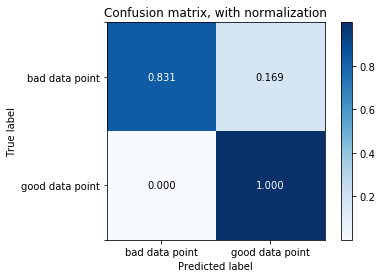

In [178]:
#What is the confusion matrix?

classThreshold =.5
modelPredThresh=1*(predictProb >= classThreshold)

# Compute confusion matrix
cnfMatrix = confusion_matrix(targetTestIn , modelPredThresh)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
classNames = ['bad data point','good data point']
plotConfusionMatrix(cnfMatrix, classes=classNames,normalize=True,
                    title='Confusion matrix, with normalization')
plt.show()


In [184]:
%%time
# Fitting a Gradient Boost
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(learning_rate=0.1, n_estimators=200)
clf.fit(featureTrain, targetTrainIn)

CPU times: user 3min 52s, sys: 54.8 ms, total: 3min 52s
Wall time: 3min 52s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [185]:
# prediction on the training dataset
trainAccuracy = 1 - np.sum(np.abs(clf.predict(featureTrain) - targetTrainIn))/len(targetTrainIn)
print('Accuracy on the train dataset is '+ str(trainAccuracy))

Accuracy on the train dataset is 0.9949470991049514


In [186]:
# prediction on the testing dataset
testAccuracy = 1 - np.sum(np.abs(clf.predict(featureTest) - targetTestIn))/len(targetTestIn)
print('Accuracy on the test dataset is '+ str(testAccuracy))

Accuracy on the test dataset is 0.9969814999866277


In [187]:
#What is the Brier Skill Score
# Function to calculate the Brier Skill Score
modelPred = clf.predict(featureTest)
BSS(trainScaled['targets'], modelPred, targetTestIn)

0.7861041265539978

In [188]:
roc(targetTestIn,modelPred)

0.914931271613282

In [189]:
predictProb = clf.predict_proba(featureTest)[:,1]

Normalized confusion matrix
[[8.30e-01 1.70e-01]
 [6.06e-04 9.99e-01]]
total accuracy = 0.9970


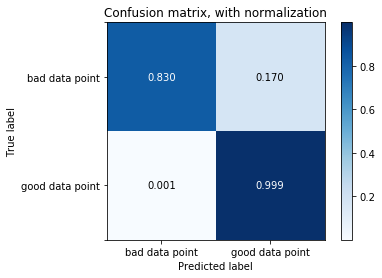

In [190]:
#What is the confusion matrix?

classThreshold =.5
modelPredThresh=1*(predictProb >= classThreshold)

# Compute confusion matrix
cnfMatrix = confusion_matrix(targetTestIn , modelPredThresh)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
classNames = ['bad data point','good data point']
plotConfusionMatrix(cnfMatrix, classes=classNames,normalize=True,
                    title='Confusion matrix, with normalization')
plt.show()
